# 1. Data ingestion

### Pandas

In [6]:
import pandas as pd

def data_ingestion_pandas(file_path: str = 'inputs/market_data-1.csv'):

    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.index = df.index.astype('datetime64[us]')
    return df

df_pandas = data_ingestion_pandas()
df_pandas


,symbol,price
timestamp,,
2025-10-01 09:30:00,AAPL,169.89
2025-10-01 09:30:00,MSFT,320.22
2025-10-01 09:30:00,SPY,430.06
2025-10-01 09:30:01,AAPL,169.41
2025-10-01 09:30:01,MSFT,319.76
...,...,...
2025-10-02 13:16:38,MSFT,321.47
2025-10-02 13:16:38,SPY,539.68
2025-10-02 13:16:39,AAPL,92.07


### Polars

In [8]:
import polars as pl

def data_ingestion_polars(file_path: str = 'inputs/market_data-1.csv'):

    df = pl.read_csv(file_path, try_parse_dates=True)
    return df

df_polars = data_ingestion_polars()
df_polars

timestamp,symbol,price
datetime[μs],str,f64
2025-10-01 09:30:00,"""AAPL""",169.89
2025-10-01 09:30:00,"""MSFT""",320.22
2025-10-01 09:30:00,"""SPY""",430.06
2025-10-01 09:30:01,"""AAPL""",169.41
2025-10-01 09:30:01,"""MSFT""",319.76
…,…,…
2025-10-02 13:16:38,"""MSFT""",321.47
2025-10-02 13:16:38,"""SPY""",539.68
2025-10-02 13:16:39,"""AAPL""",92.07


### Check

In [9]:
df_pandas.equals(df_polars.to_pandas().set_index('timestamp'))

True

### Timing

In [10]:
import time

# Time pandas ingestion
start_pandas = time.time()
_ = data_ingestion_pandas()
end_pandas = time.time()
pandas_time = end_pandas - start_pandas

# Time polars ingestion
start_polars = time.time()
_ = data_ingestion_polars()
end_polars = time.time()
polars_time = end_polars - start_polars

print(f"Pandas ingestion time: {pandas_time:.6f} seconds")
print(f"Polars ingestion time: {polars_time:.6f} seconds")


Pandas ingestion time: 0.097849 seconds
Polars ingestion time: 0.004770 seconds


### Memory

In [11]:
import sys

# Memory usage for pandas ingestion
df_pandas_mem = df_pandas.memory_usage(deep=True).sum() / (1024 ** 2)  # In MB

# Memory usage for polars ingestion (via conversion to pandas, as polars doesn't give exact memory per df easily)
df_polars_mem = df_polars.to_pandas().memory_usage(deep=True).sum() / (1024 ** 2)  # In MB

print(f"Pandas memory usage: {df_pandas_mem:.2f} MB")
print(f"Polars memory usage (converted to pandas): {df_polars_mem:.2f} MB")


Pandas memory usage: 19.65 MB
Polars memory usage (converted to pandas): 19.65 MB


# 2. Rolling metrics

In [12]:
df_pandas['price'].rolling(window=20).mean()

timestamp
2025-10-01 09:30:00         NaN
2025-10-01 09:30:00         NaN
2025-10-01 09:30:00         NaN
2025-10-01 09:30:01         NaN
2025-10-01 09:30:01         NaN
                         ...   
2025-10-02 13:16:38    306.4500
2025-10-02 13:16:38    328.8885
2025-10-02 13:16:39    317.3715
2025-10-02 13:16:39    306.5225
2025-10-02 13:16:39    328.9125
Name: price, Length: 300000, dtype: float64

In [15]:
def compute_rolling_metrics_pandas(df_pandas):

    df_pandas_metrics = pd.DataFrame()

    for symbol in df_pandas['symbol'].unique():

        df_pandas_symbol = df_pandas[df_pandas['symbol'] == symbol]

        df_mean = df_pandas_symbol['price'].rolling(window=20).mean()
        df_mean.name = f"mean_{symbol}"
        df_pandas_metrics = pd.concat([df_pandas_metrics, df_mean], axis=1)

        df_std = df_pandas_symbol['price'].rolling(window=20).std()
        df_std.name = f"std_{symbol}"   
        df_pandas_metrics = pd.concat([df_pandas_metrics, df_std], axis=1)
        
        df_sharpe = df_mean / df_std
        df_sharpe.name = f"sharpe_{symbol}"
        df_pandas_metrics = pd.concat([df_pandas_metrics, df_sharpe], axis=1)

    return df_pandas_metrics

df_pandas_metrics = compute_rolling_metrics_pandas(df_pandas)
df_pandas_metrics


,mean_AAPL,std_AAPL,sharpe_AAPL,mean_MSFT,std_MSFT,sharpe_MSFT,mean_SPY,std_SPY,sharpe_SPY
2025-10-01 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-01 09:30:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-01 09:30:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-01 09:30:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-01 09:30:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-10-02 13:16:35,90.6525,0.459964,197.085972,323.5530,0.839023,385.630845,537.8915,0.679119,792.042834
2025-10-02 13:16:36,90.6750,0.495713,182.918267,323.4230,0.833787,387.896348,538.0010,0.731220,735.757725
2025-10-02 13:16:37,90.6950,0.523596,173.215653,323.2795,0.866873,372.926182,538.1060,0.784665,685.778126
2025-10-02 13:16:38,90.7395,0.564721,160.680115,323.1150,0.883149,365.866803,538.2340,0.823212,653.821908


In [17]:
def compute_rolling_metrics_polars(df_polars):

    # Compute rolling mean, std, and sharpe by symbol in Polars
    rolling_window = 20
    # Calculate rolling metrics for each symbol separately
    df_polars_metrics = df_polars.with_columns([
        pl.col("price").rolling_mean(rolling_window).over("symbol").alias("rolling_mean"),
        pl.col("price").rolling_std(rolling_window).over("symbol").alias("rolling_std"),
    ])

    # Calculate sharpe ratio
    df_polars_metrics = df_polars_metrics.with_columns([
        (pl.col("rolling_mean") / pl.col("rolling_std")).alias("rolling_sharpe")
    ])

    # Pivot to get separate columns for each symbol
    df_polars_metrics_pivoted = df_polars_metrics.pivot(
        index="timestamp",
        columns="symbol", 
        values=["rolling_mean", "rolling_std", "rolling_sharpe"],
        aggregate_function="first"
    )

    # Rename columns to match the pandas output format
    df_polars_metrics_final = df_polars_metrics_pivoted.select([
        "timestamp",
        pl.col("rolling_mean_AAPL").alias("mean_AAPL"),
        pl.col("rolling_std_AAPL").alias("std_AAPL"), 
        pl.col("rolling_sharpe_AAPL").alias("sharpe_AAPL"),
        pl.col("rolling_mean_MSFT").alias("mean_MSFT"),
        pl.col("rolling_std_MSFT").alias("std_MSFT"),
        pl.col("rolling_sharpe_MSFT").alias("sharpe_MSFT"),
        pl.col("rolling_mean_SPY").alias("mean_SPY"),
        pl.col("rolling_std_SPY").alias("std_SPY"),
        pl.col("rolling_sharpe_SPY").alias("sharpe_SPY"),
    ])

    return df_polars_metrics_final

df_polars_metrics = compute_rolling_metrics_polars(df_polars)
df_polars_metrics

/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_60889/3107494682.py:17: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_polars_metrics_pivoted = df_polars_metrics.pivot(


timestamp,mean_AAPL,std_AAPL,sharpe_AAPL,mean_MSFT,std_MSFT,sharpe_MSFT,mean_SPY,std_SPY,sharpe_SPY
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-10-01 09:30:00,null,null,null,null,null,null,null,null,null
2025-10-01 09:30:01,null,null,null,null,null,null,null,null,null
2025-10-01 09:30:02,null,null,null,null,null,null,null,null,null
2025-10-01 09:30:03,null,null,null,null,null,null,null,null,null
2025-10-01 09:30:04,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…
2025-10-02 13:16:35,90.6525,0.459964,197.085972,323.553,0.839023,385.630845,537.8915,0.679119,792.042834
2025-10-02 13:16:36,90.675,0.495713,182.918267,323.423,0.833787,387.896348,538.001,0.73122,735.757725
2025-10-02 13:16:37,90.695,0.523596,173.215653,323.2795,0.866873,372.926182,538.106,0.784665,685.778126


### Timing

In [18]:
import time

# Time pandas ingestion
start_pandas = time.time()
_ = compute_rolling_metrics_pandas(df_pandas)
end_pandas = time.time()
pandas_time = end_pandas - start_pandas

# Time polars ingestion
start_polars = time.time()
_ = compute_rolling_metrics_polars(df_polars)
end_polars = time.time()
polars_time = end_polars - start_polars

print(f"Pandas rolling metrics time: {pandas_time:.6f} seconds")
print(f"Polars rolling metrics time: {polars_time:.6f} seconds")


Pandas rolling metrics time: 1.168358 seconds
Polars rolling metrics time: 0.031780 seconds


/var/folders/f0/gc3h36y11691l12q208g38l80000gn/T/ipykernel_60889/3107494682.py:17: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_polars_metrics_pivoted = df_polars_metrics.pivot(


### Visualization

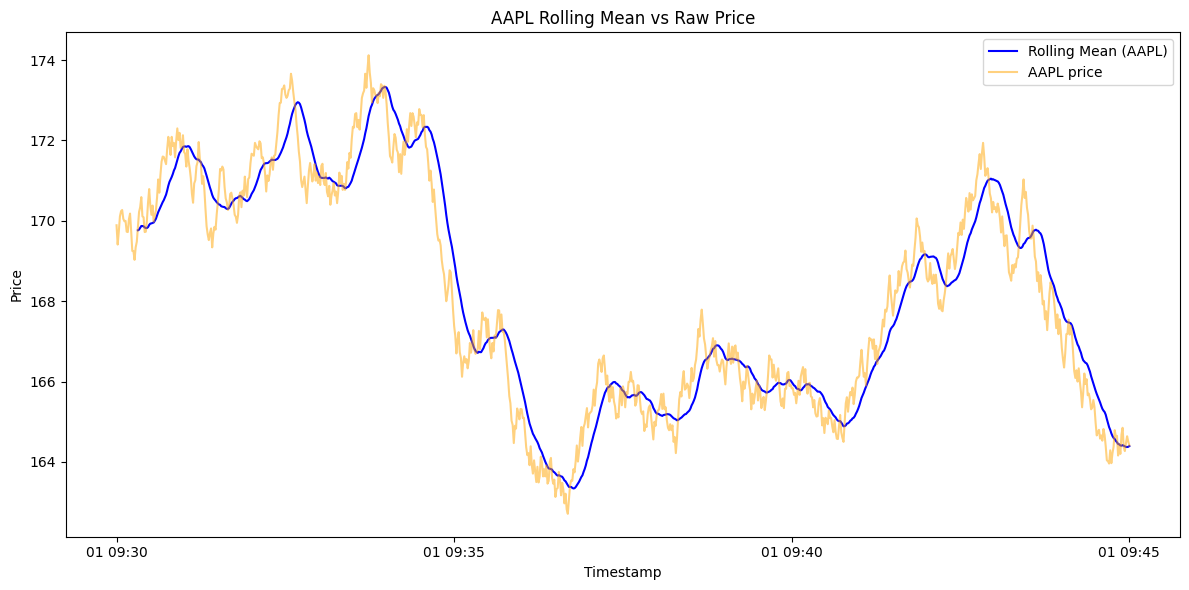

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Filter data between 9:30 and 10:30 (assuming same day)
start_time = df_pandas_metrics.index[0].replace(hour=9, minute=30, second=0)
end_time = df_pandas_metrics.index[0].replace(hour=9, minute=45, second=0)

# Plot rolling mean of AAPL (from metrics DataFrame, indexed by timestamp)
mask_metrics = (df_pandas_metrics.index >= start_time) & (df_pandas_metrics.index <= end_time)
plt.plot(df_pandas_metrics.index[mask_metrics], df_pandas_metrics['mean_AAPL'][mask_metrics], label='Rolling Mean (AAPL)', color='blue')

# Plot individual AAPL prices from the original DataFrame, for symbol == "AAPL"
aapl_mask = df_pandas['symbol'] == 'AAPL'
mask_aapl_time = (df_pandas[aapl_mask].index >= start_time) & (df_pandas[aapl_mask].index <= end_time)
plt.plot(df_pandas[aapl_mask][mask_aapl_time].index, df_pandas[aapl_mask][mask_aapl_time]['price'], label='AAPL price', color='orange', alpha=0.5)

plt.title('AAPL Rolling Mean vs Raw Price')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

### Discussion

Polars rolling metrics computation is much faster based on the above timing results. This is expected because Polars is optimized for parallel processing and columnar data storage, which is well-suited for the rolling metrics computation.

This could also be attributed to the lack of knowledge on my part of polars therefore that part was slightly vibecoded unlike the pandas which was I am more familiar with.

# 3. Threading vs Multiprocessing


### Discussion — GIL, multiprocessing trade-offs, and practical notes

- GIL (Global Interpreter Lock): CPython has a GIL which prevents multiple native Python bytecode threads from executing Python code at the same time. Threading can still provide concurrency for I/O-bound tasks or when using C-extensions that release the GIL. For CPU-bound numeric work implemented in pure Python, threading typically won't speed up the computation because of the GIL.

- Multiprocessing: Starts separate Python processes which each have their own interpreter and memory space — they are not limited by the GIL, so CPU-bound workloads often benefit from multiprocessing. However, multiprocessing has overhead:
  - Process startup cost (higher latency than threads).
  - Data must be pickled/unpickled when sent to workers (serializing large pandas DataFrames is expensive).
  - On some platforms/start methods (e.g., spawn), multiprocessing may fail or be slower inside interactive notebooks. Running the same code as a script (or using a `if __name__ == "__main__"` guard) can be more reliable.

- When to prefer which:
  - If your per-symbol computation is I/O-bound (e.g., network/DB reads, disk access) or uses libraries that release the GIL (numpy, pandas C-extensions, polars), threading is simpler and often sufficient.
  - If the work is CPU-bound pure-Python and benefits from multiple cores, prefer multiprocessing or a native parallel backend (numba, C/C++ extensions, libraries that parallelize in C).

# 4. Portfolio Aggregation
